In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import List,Dict,Any,Literal
import nest_asyncio
from langchain_core.output_parsers import JsonOutputParser
import os
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
import subprocess


llm = ChatOpenAI(
    model = 'hf:meta-llama/Llama-3.3-70B-Instruct',
    api_key = 'YOUR_API_KEY',
    base_url = 'https://glhf.chat/api/openai/v1'
)

/home/talha/anaconda3/envs/langgraph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SetupFiles(BaseModel):
    readme : str = Field(description="The readme file of the repo")
    requirements : str = Field(description="The requirements file of the repo")

class container_setup(BaseModel):
    dockerfile : str = Field(description="The docker file content")
    dockerfile_status : bool = Field(description="The status of the dockerfile key in the json")
    commands : List[str] = Field(description="The commands to run the docker file and the repo")

folder_parser = JsonOutputParser(pydantic_object=SetupFiles)

class State(MessagesState):
    github_repo_url : str
    imp_files: SetupFiles
    execution_commands: container_setup
    repo_structure: str

In [3]:
def assistant(state: State):
    print(f'assistant state = {state}')
    return {'messages': llm.invoke(state['messages'])}

In [4]:

format_dir = """
Output the directory content in following format:
{
    readme : path of readme if exist else empty strings like "" (eg: ./folder1/folder2/README.md)
    requirements : path of requirements if exist else empty strings like "" (eg: ./folder1/folder2/requirements.txt)
}

OUTPUT SHOULD BE THE ABOVE JSON FORMAT ANY NOTHING ELSE NOT EVEN A SINGLE CHARACTER EXTRA, NO EXPLANATION , NOTHING ELSE JUST THE JSON FORMAT.
"""
  
def clone_repo(state: State):
    print(f'clone state = {state}')
    os.system(f"git clone {state['github_repo_url']}")
    os.chdir(state['github_repo_url'].split('/')[-1])
    print(f"Current directory = {os.getcwd()}")
    directory_content = os.popen(f"ls -R ./").read()
    messages = [HumanMessage(content=f"OUTPUT FROM CLONE_REPO NODE:\nCloned the repository. The directory structure of repo is: {directory_content}.")]
    output = llm.invoke(messages + [HumanMessage(content=format_dir)])
    parsed_output = folder_parser.parse(output.content)
    print(f'parsed_output = {parsed_output}')
    # print(directory_content)
    return {'messages': messages,'imp_files': parsed_output, 'repo_structure': directory_content}

In [5]:
readme_prompt = """
Find the setup instructions in the readme file and output only the setup instructions part in a well formatted manner if setup instructions are present otherwise no if not present. 
Output should be setup instructions or no, and nothing else.
Remember to output the setup instructions only and not the entire readme file.
"""
def get_readme(state: State):
    print(f'get_readme state = {state}')
    readme_content = os.popen(f"cat {state['imp_files']['readme']}").read()
    messages = [HumanMessage(content=f"Readme content: {readme_content}"), HumanMessage(content=readme_prompt)]
    output = llm.invoke(messages)
    print(output)
    if "no" in output.content:
        return {'messages': [HumanMessage(content='There is no setup instructions in the readme file')]}
    return {'messages': [HumanMessage(content=f'The setup instructions from README file of this repo are: {readme_content}')]}

In [6]:
def check_readme(state: State) -> Literal["get_readme", "plan"]:
    print('check_readme called!!!')
    if state['imp_files']['readme']:
        return "get_readme"
    return "plan"

In [7]:
plan_prompt = """
## Task

Create a step-by-step plan to set up a GitHub repository on my Linux PC using Docker. The repository has already been cloned, and we are currently in that directory.

## Instructions

1. **Detailed Steps:** Provide a thorough plan, including every step needed to get the repository running.
2. **Docker Setup:**  Assume Docker, Docker Compose, and all related components are installed. The setup must be done entirely within a Docker container.
3. **Starting Point:** Begin your plan from the current state: the repository is cloned, and we have already changed the directory to repository's.
4. **Include All Essentials:** Your plan should list all necessary commands, code (like Dockerfiles), and any other actions required.
5. **Execution:** Remember, any command you include will be executed directly in the terminal.
6. **System:** The operating system is Arch Linux, So tailor you commands accordingly.

# Command Instructions
- **Avoid using `cd`:** We are already in the right directory after cloning the repository. So, avoid using `cd repository` in your plan.

# For Python Repositories
- **Python Version:** Use Python 3.10 or later.
- **Dependency installation:** Use only requirements.txt for dependency installation. Do not install any dependency directly using `pip install` and leave them if there is no requirements.txt.

## Output Format

Provide a detailed plan to set up the repository. This plan should include:

-   **Dockerfile:** If a Dockerfile is not present in the repository, provide the content for one. If it exists, leave this field empty (e.g., "").
-   **Commands:** A list of commands to build and run the Docker container.

**Strictly adhere to the following JSON format without any backticks:**

{
    "dockerfile": "Content of Dockerfile or empty string",
    "dockerfile_status": "True/False (false if dockerfile key content is empty else true)",
    "commands": ["List of commands"]
}

**Do not output any single character outside of this JSON structure.**
"""

container_parser = JsonOutputParser(pydantic_object=container_setup)
def plan(state: State):
    print(f'plan state = {state}')
    messages = [HumanMessage(content=plan_prompt)]
    output = llm.invoke(state['messages']+messages)
    parsed_output = container_parser.parse(output.content)
    return {'messages': [output], 'execution_commands': parsed_output}
    


In [8]:
def execute_commands(state: State):
    print(f'execute_commands state = {state}')
    print(f"Exection commands = {state['execution_commands']}")
    if state['execution_commands']['dockerfile_status']:
        with open("Dockerfile", "w") as f:
            f.write(state['execution_commands']['dockerfile'])
    #store and print the output of each command
    combined_output = ""
    for command in state['execution_commands']['commands']:
        combined_output += f"\n#Output of command: **{command}:**\n"
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        # combined_output += stdout.decode()
        combined_output += stderr.decode()
        combined_output += "\n\n"
    print(f"Combined output = {combined_output}")
    return {'messages': [HumanMessage(content=combined_output)]}

In [9]:
def check_errors(state: State) -> Literal["fix_errors", END]:
    print(f'check_errors state = {state}')
    message = state['messages'][-1]
    print('+'*50)
    print(f"Message = {message}")
    output = llm.invoke([message,HumanMessage(content="Above message is the output of the commands execution. if there is any error just output yes else no. The output should be yes or no and nothing else.")])
    if "yes" in output.content:
        print('!'*50)
        print("Error detected!!!")
        return "fix_errors"
    return END

In [10]:
output_schema = """
## Output Format

Provide a detailed plan to set up the repository. This plan should include:

-   **Dockerfile:** If a Dockerfile is not present in the repository, provide the content for one. If it exists, leave this field empty (e.g., "").
-   **Commands:** A list of commands to build and run the Docker container.

**Strictly adhere to the following JSON format without any backticks:**

{
    "dockerfile": "Content of Dockerfile or empty string",
    "dockerfile_status": "True/False (false if dockerfile key content is empty else true)",
    "commands": ["List of commands"]
}

**Do not output any single character outside of this JSON structure.**
"""
def fix_errors(state: State):
    print(f'fix_errors state = {state}')
    output = llm.invoke(state['messages']+[HumanMessage(content=f"There is an error after execution of commands as you can see in the last previous message. Fix the error and rewrite docker file and commands.\n\n {output_schema}")])
    parsed_output = container_parser.parse(output.content)
    return {'messages': [HumanMessage(content="Fix the error"),output], 'execution_commands': parsed_output}

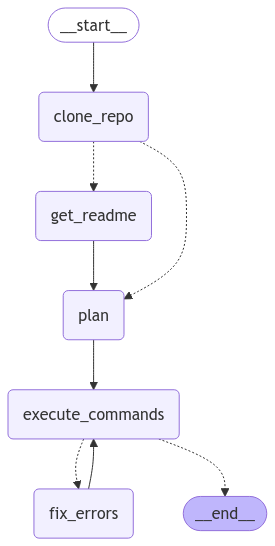

In [11]:
workflow = StateGraph(State)
workflow.add_node('clone_repo', clone_repo)
workflow.add_node('get_readme', get_readme)
workflow.add_node('plan', plan)
workflow.add_node('execute_commands', execute_commands)
workflow.add_node('fix_errors', fix_errors)
workflow.add_edge(START,'clone_repo')
workflow.add_conditional_edges(
    "clone_repo",
    check_readme
)
workflow.add_edge('get_readme', 'plan')
workflow.add_edge('plan', 'execute_commands')
workflow.add_conditional_edges(
    'execute_commands',
    check_errors
)
workflow.add_edge('fix_errors', 'execute_commands')
workflow.set_entry_point('clone_repo')
graph = workflow.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
system_prompt = """
You are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any github online repository on user's PC.
If an Output schema is defined by the user then do not output any single character other than that schema
"""

In [13]:
config = {"configurable": {"thread_id": "5"}}
# https://github.com/deviant101/Find-GitHub-Repos-StarLang
# https://github.com/GeorgeZhukov/python-snake
if os.path.exists("python-snake"):
    os.system("rm -r python-snake")
messages = [SystemMessage(content=system_prompt)]
output = graph.invoke({'messages': messages,'github_repo_url': 'https://github.com/Talha-Ali-5365/SOS-Game',"recursion_limit": 100},config)
for m in output['messages'][-1:]:
    m.pretty_print()

clone state = {'messages': [SystemMessage(content="\nYou are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any github online repository on user's PC.\nIf an Output schema is defined by the user then do not output any single character other than that schema\n", additional_kwargs={}, response_metadata={}, id='434f192f-5457-4218-8356-9c84ca299ad7')], 'github_repo_url': 'https://github.com/Talha-Ali-5365/SOS-Game'}


Cloning into 'SOS-Game'...


Current directory = /home/talha/Developers/langgraph/instant-run/SOS-Game
parsed_output = {'readme': '', 'requirements': ''}
check_readme called!!!
plan state = {'messages': [SystemMessage(content="\nYou are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any github online repository on user's PC.\nIf an Output schema is defined by the user then do not output any single character other than that schema\n", additional_kwargs={}, response_metadata={}, id='434f192f-5457-4218-8356-9c84ca299ad7'), HumanMessage(content='OUTPUT FROM CLONE_REPO NODE:\nCloned the repository. The directory structure of repo is: ./:\nbox.h\nsos.c\nsos.exe\n.', additional_kwargs={}, response_metadata={}, id='4f6a7d60-6df2-4f15-b0da-1c9bbfb91b11')], 'github_repo_url': 'https://github.com/Talha-Ali-5365/SOS-Game', 'imp_files': {'readme': '', 'requirements': ''}, 'repo_structure': './:\nbox.h\nsos.c\nsos.exe\n'}
execute_commands state = {'messages': [SystemMessage(content="\nYou are a helpful AI 

In [38]:
temp_state = graph.get_state(config)
temp_state.next

()

In [39]:
import pprint
pprint.pprint(temp_state[0])

{'execution_commands': {'commands': ['docker build -t python-snake '
                                     'python-snake/',
                                     'docker run -it python-snake'],
                        'dockerfile': 'FROM python:3.10-slim\n'
                                      'WORKDIR /app\n'
                                      'COPY python-snake/requirements.txt ./\n'
                                      'RUN pip install --no-cache-dir -r '
                                      'requirements.txt\n'
                                      'COPY python-snake/ ./python-snake\n'
                                      'WORKDIR /app/python-snake\n'
                                      'CMD ["python", "snake.py"]'},
 'github_repo_url': 'https://github.com/GeorgeZhukov/python-snake',
 'imp_files': {'readme': './python-snake/README.md', 'requirements': ''},
 'messages': [SystemMessage(content="\nYou are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any 

In [29]:
messages = temp_state[0]['messages']

In [30]:
messages += [HumanMessage(content=f"after execution:  error requirements.txt not found.\n\n Strictly follow the output schema as methioned before in the messages.\n\n {output_schema}")]

In [31]:
messages

[SystemMessage(content="\nYou are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any github online repository on user's PC.\nIf an Output schema is defined by the user then do not output any single character other than that schema\n", additional_kwargs={}, response_metadata={}, id='7479b694-3e12-4d58-b558-7bcf4b010849'),
 HumanMessage(content='OUTPUT FROM CLONE_REPO NODE:\nCloned the repository. The directory structure of repo is: python-snake/:\nLICENSE\nREADME.md\nsnake.py\n.', additional_kwargs={}, response_metadata={}, id='ca9c85bc-cfc9-4867-a4d1-0c9de4f0f8eb'),
 HumanMessage(content='The setup instructions from README file of this repo are: # python-snake\nSimple terminal snake game written on python.\n\n##### Also C++ version available\n~https://github.com/GeorgeZhukov/cpp-snake~\n\n## Dependencies\n* curses\n\n## Run\npython snake.py\n\n## Control\nUp Arrow, Down Arrow, Left Arrow, Right Arrow.\n', additional_kwargs={}, response_metadata={}, id='b7f981e6-58

In [32]:
output = llm.invoke(messages)

In [33]:
pprint.pprint(output.content)

('{\n'
 '    "dockerfile": "FROM python:3.10-slim\n'
 'RUN pip install windows-curses\n'
 'WORKDIR /app\n'
 'COPY python-snake/ .\n'
 'CMD [\\"python\\", \\"snake.py\\"]",\n'
 '    "commands": [\n'
 '        "docker build -t python-snake python-snake/",\n'
 '        "docker run -it python-snake"\n'
 '    ]\n'
 '}')


In [62]:
messages += [output, HumanMessage(content="""after execution:  ERROR:   7 | >>> COPY python-snake/ /app/   8 |        9 |     CMD ["python", "snake.py"]--------------------ERROR: failed to solve: failed to compute cache key: failed to calculate checksum of ref 12e9717e-ed7b-4a53-9d9e-97a50cfe503a::hzl53phjf2nxxzzakrzfd0opl: "/python-snake": not found""")]

In [63]:
messages

[SystemMessage(content="\nYou are a helpful AI ASSISTANT inside a complex Agentic graph that can setup any github online repository on user's PC.\nIf an Output schema is defined by the user then do not output any single character other than that schema\n", additional_kwargs={}, response_metadata={}, id='7071eceb-4507-4346-82ed-4bbdfea32b6b'),
 HumanMessage(content='OUTPUT FROM CLONE_REPO NODE:\nCloned the repository. The directory structure of repo is: python-snake/:\nLICENSE\nREADME.md\nsnake.py\n.', additional_kwargs={}, response_metadata={}, id='212eb3b6-1953-434f-9bf2-782a934ee420'),
 HumanMessage(content='The setup instructions from README file of this repo are: # python-snake\nSimple terminal snake game written on python.\n\n##### Also C++ version available\n~https://github.com/GeorgeZhukov/cpp-snake~\n\n## Dependencies\n* curses\n\n## Run\npython snake.py\n\n## Control\nUp Arrow, Down Arrow, Left Arrow, Right Arrow.\n', additional_kwargs={}, response_metadata={}, id='af66af38-42

In [64]:
output = llm.invoke(messages)

In [66]:
pprint.pprint(output.content)

('The issue here is that the `COPY` instruction in the Dockerfile is trying to '
 "copy the `python-snake/` directory from the current directory, but it's not "
 'finding it. This is because the `WORKDIR` instruction has changed the '
 'current directory to `/app`.\n'
 '\n'
 'Since we are building the Docker image from the `python-snake/` directory, '
 'we can simply copy the current directory (`.`) to the `/app` directory. '
 "Here's an updated output:\n"
 '\n'
 '{\n'
 '    "dockerfile": "FROM python:3.10-slim\\nWORKDIR /app\\nRUN pip install '
 'windows-curses\\nCOPY . .\\nCMD [\\"python\\", \\"snake.py\\"]",\n'
 '    "commands": [\n'
 '        "docker build -t python-snake .",\n'
 '        "docker run -it python-snake"\n'
 '    ]\n'
 '}')


In [70]:
messages += [output, HumanMessage(content="""after execution:  ERROR: failed to solve: process "/bin/sh -c pip install windows-curses" did not complete successfully: exit code: 1""")]

In [71]:
output = llm.invoke(messages)

In [72]:
pprint.pprint(output.content)

('The error message indicates that the `pip install windows-curses` command '
 'failed. This is because `windows-curses` is a Windows-specific package and '
 "it's not compatible with the Linux-based Python image we're using.\n"
 '\n'
 "Since we're building a Docker image, we should use a package that's "
 "compatible with Linux. The `curses` library is available on Linux, but it's "
 "not a Python package, it's a system library. We can install it using the "
 'package manager.\n'
 '\n'
 "Here's an updated output:\n"
 '\n'
 '{\n'
 '    "dockerfile_content": "FROM python:3.10-slim\\nRUN apt update && apt '
 'install -y libncurses5-dev\\nRUN pip install\\nWORKDIR /app\\nCOPY . .\\nCMD '
 '[\\"python\\", \\"snake.py\\"]",\n'
 '    "filename": "Dockerfile",\n'
 '    "commands": [\n'
 '        "echo \'FROM python:3.10-slim\' > Dockerfile",\n'
 '        "echo \'RUN apt update && apt install -y libncurses5-dev\' >> '
 'Dockerfile",\n'
 '        "echo \'RUN pip install\' >> Dockerfile",\n'
 ' 